---
title: 'bear detector'
description: 'fastai book chapter 3'
date: "2023-08-14"
date-format: iso
image: your_deep_learning_journey_thumbnail.jpg
categories: [fastai, deeplearning, self-study]
toc: true
draft: false
title-block-banner: false
---

[blog](../../../blog.qmd) > [ from model to production](../from_model_to_production_post.ipynb) > bear detector 
---

In [1]:
from fastai.vision.all import *
from fastai.vision.widgets import *

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from torch import *
from duckduckgo_search import DDGS
from fastdownload import download_url

# check cuda
if torch.cuda.is_available():
    print('We have GPU!')
else:
    print('Sorry, CPU only')

We have GPU!


In [2]:
def search_images(term, max_images=200):
    print(f"'Searching for '{term}'")
    result = DDGS().images(keywords=term,max_results=max_images)
    print(result)
    return L(result).itemgot('image')

In [3]:
urls = search_images('bear photo', max_images=1)
urls[0]

'Searching for 'bear photo'
[{'title': '200+ Incredible Bear Pictures · Pexels · Free Stock Photos', 'image': 'https://images.pexels.com/photos/162340/bear-bavarian-bear-wild-brown-bear-162340.jpeg?cs=srgb&dl=animal-bear-cute-162340.jpg&fm=jpg', 'thumbnail': 'https://tse2.mm.bing.net/th?id=OIP.KFInEXIAdf3WeeTP-lrFxAHaE8&pid=Api', 'url': 'https://www.pexels.com/search/bear/', 'height': 3744, 'width': 5616, 'source': 'Bing'}]


'https://images.pexels.com/photos/162340/bear-bavarian-bear-wild-brown-bear-162340.jpeg?cs=srgb&dl=animal-bear-cute-162340.jpg&fm=jpg'

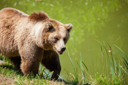

In [4]:
dest = "bear.jpg"
download_url(urls[0],dest)

im = Image.open(dest)
im.to_thumb(128,128)


In [5]:
searches = 'teddy','black','grizzly'
path = Path('bears')

for o in searches:
    dest = (path/o)
    if not dest.exists():
        download_images(dest, urls=search_images(f'{o} bear'))
        dest.mkdir(exist_ok=True, parents=True)
        resize_images(path/o, max_size=400, dest=path/o)
    time.sleep(4)

In [6]:
fns = get_image_files(path)
fns

(#445) [Path('bears/black/f677b4f3-a172-4be0-a2a7-446e2d56077c.jpg'),Path('bears/black/148ecc46-66c6-438b-9fc0-ee107056a079.jpg'),Path('bears/black/c69551f2-9516-4bed-bdea-c81b6320ec85.jpg'),Path('bears/black/8dbfad12-3b01-431c-9610-5e8855649428.jpeg'),Path('bears/black/92003174-bb33-46ba-ac0c-9671be84dcec.jpg'),Path('bears/black/fd12da45-662c-4fe7-8fc6-32f915b4024c.jpg'),Path('bears/black/93fa2a43-1195-4e19-ab91-ba391de684f9.jpg'),Path('bears/black/b4835947-6ae9-4ed0-9891-5cf44fcd524f.jpg'),Path('bears/black/5d30c339-0fa1-4dc2-a52a-3ff512a6ce69.jpg'),Path('bears/black/0234f185-166a-42c6-83bb-e5abcf215e9f.jpg')...]

In [7]:
failed = verify_images(fns)
failed

(#0) []

In [8]:
failed.map(Path.unlink)

(#0) []

In [9]:
for o in searches:
    dest = (path/o)
    for image in os.listdir(dest):
        new_filename = os.path.splitext(image)[0]+'.png'
        im = Image.open(dest/image)
        if im.format == "PNG" or im.format == "GIF":
            if im.mode != "RGBA":
                im.convert("RGBA")
                im.save(dest/new_filename)
                os.remove(dest/image)

In [10]:
bears = DataBlock(
    blocks = (ImageBlock,CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.2, seed=42),
    get_y = parent_label,
    item_tfms = Resize(128)
)

In [11]:
dls = bears.dataloaders(path)

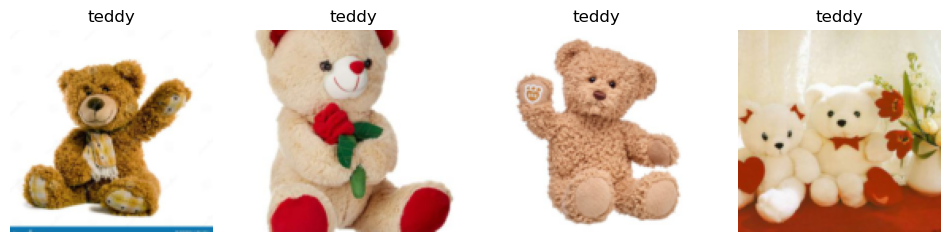

In [12]:
dls.valid.show_batch(max_n=4,nrows=1)

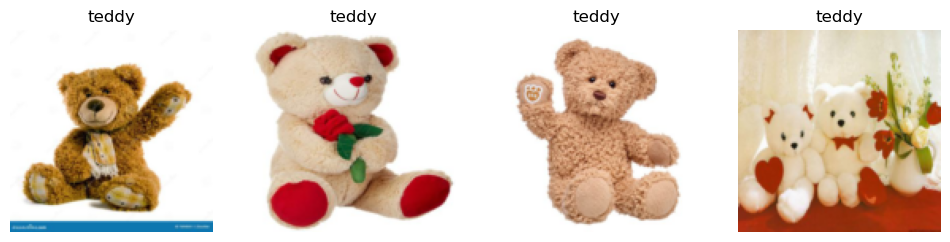

In [13]:
bears = bears.new(item_tfms=Resize(128,ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4,nrows=1)

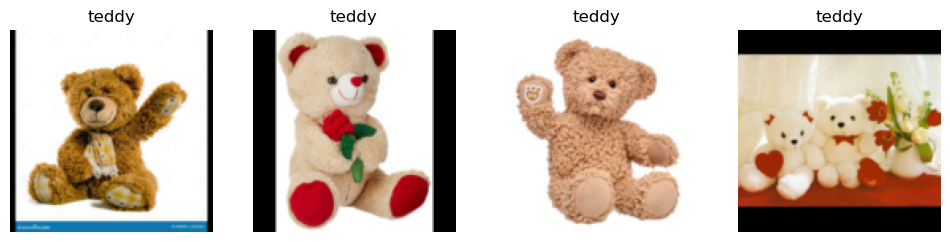

In [14]:
bears = bears.new(item_tfms=Resize(128,ResizeMethod.Pad,pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

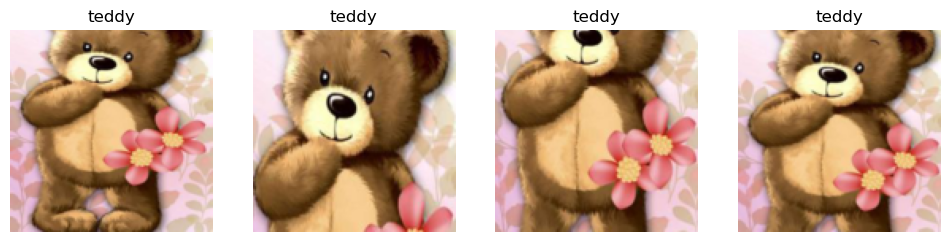

In [15]:
bears = bears.new(item_tfms=RandomResizedCrop(128,min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

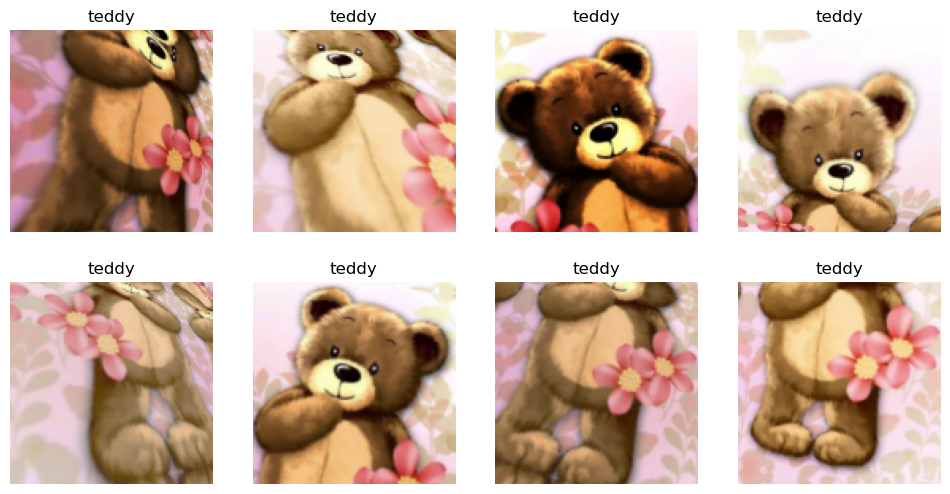

In [16]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [17]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224,min_scale=0.5),
    batch_tfms=aug_transforms())


dls = bears.dataloaders(path)

In [18]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.132481,0.225681,0.044944,00:01


/home/jf/miniconda3/envs/FastAi/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608883701/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


epoch,train_loss,valid_loss,error_rate,time
0,0.241915,0.200651,0.022472,00:01
1,0.151688,0.212490,0.022472,00:01
2,0.127084,0.231750,0.022472,00:01
3,0.105303,0.229853,0.022472,00:01


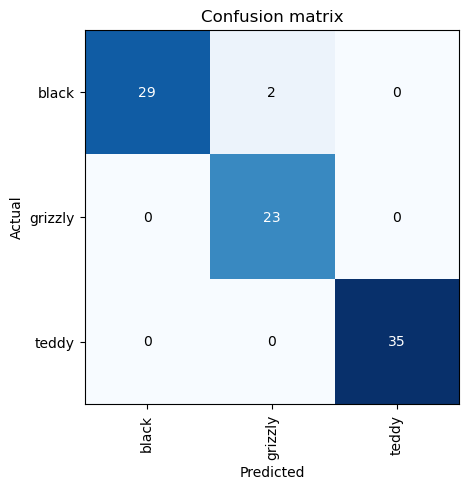

In [19]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

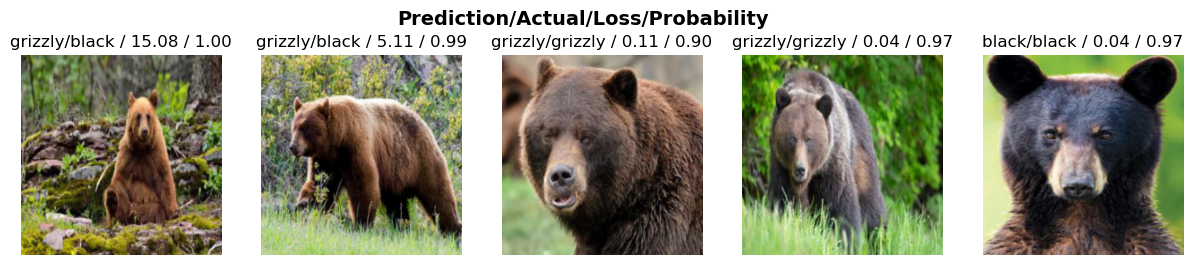

In [20]:
interp.plot_top_losses(5,nrows=1)

In [21]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [22]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [23]:
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [24]:
learn.export()

In [25]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [26]:
learn_inf = load_learner(path/'export.pkl')

In [27]:
learn_inf.predict('bear.jpg')

('grizzly', tensor(1), tensor([5.1512e-04, 9.9945e-01, 3.9191e-05]))

In [28]:
learn_inf.predict('dog_or_bear.jpg')

('black', tensor(0), tensor([0.9271, 0.0088, 0.0641]))

In [29]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

In [30]:
uploader = widgets.FileUpload()
display(uploader)

FileUpload(value=(), description='Upload')

In [33]:
print(uploader)

FileUpload(value=({'name': 'bear.jpg', 'type': 'image/jpeg', 'size': 3004907, 'content': <memory at 0x7e10f4961400>, 'last_modified': datetime.datetime(2024, 11, 1, 21, 41, 19, 680000, tzinfo=datetime.timezone.utc)},), description='Upload')


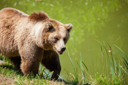

In [34]:
uploaded_file = list(uploader.value)[0]  # Access the first file
content = uploaded_file['content']

# Load the image with PIL
image = Image.open(io.BytesIO(content))
image.to_thumb(128,128)

In [35]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(image.to_thumb(128,128))

out_pl

Output()

In [36]:
pred, pred_idx, probs = learn_inf.predict(image)

In [37]:
lbl_pred = widgets.Text()
lbl_pred.value = f"Prediction: {pred}; Probability: {probs[pred_idx]:.04f}"
lbl_pred

Text(value='Prediction: grizzly; Probability: 0.9994')

In [38]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [39]:
def on_click_classify(cange):
    uploaded_file = list(uploader.value)[0]  # Access the first file
    content = uploaded_file['content']
    # Load the image with PIL
    img = Image.open(io.BytesIO(content))
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value =  f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

In [40]:
btn_run.on_click(on_click_classify)

In [41]:
display(VBox([widgets.Label('Select your bear!'), uploader, btn_run, out_pl, lbl_pred]))